In [48]:
import torch

import numpy as np

from sbi.analysis import pairplot
from sbi.inference import NPE,NLE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from torch.distributions import Normal, Independent,InverseGamma

In [49]:
num_dim = 2  # Here, num_dim = 2 indicates we have two parameters: μ and σ

# Define the simulator function
# torch.randn: Generates random numbers following a standard normal distribution 
# (mean = 0, standard deviation = 1).
def simulator(theta, n=1000):
    # theta[0] is μ, theta[1] is σ
    mu, sigma = theta[0], theta[1]
    return mu + np.sqrt(sigma) * torch.randn(n)  # Generate n observations

# torch.ones(num_dim) defines the dimension of the parameters

# prior = BoxUniform(low= -2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
# Must use torch.distributions because sampling is required
prior = [
    Normal(torch.tensor([0.0]), torch.tensor([1.0])), 
    InverseGamma(torch.tensor([2.0]), torch.tensor([1.0]))
]


In [50]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_60648/3563422826.py:1: UserWarning: Prior was provided as a sequence of 2 priors. They will be interpreted as independent of each other and matched in order to the components of the parameter.
  prior, num_parameters, prior_returns_numpy = process_prior(prior)


In [51]:
inference = NPE(prior=prior)

# Generate simulation data
num_simulations = 500
theta = prior.sample((num_simulations,))
x = simulator(theta)

# Print and check shapes
print("theta.shape", theta.shape)
print("x.shape", x.shape)


theta.shape torch.Size([500, 2])
x.shape torch.Size([500, 1000])


In [52]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 242 epochs.

In [53]:
posterior = inference.build_posterior(density_estimator)
theta_true = torch.tensor([[0,0.3]]) 
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [54]:
import numpy as np

# Prior parameters
mu_0 = 0
sigma_0_sq = 1  # Prior variance
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Data preparation
Z = x_obs.numpy()  # If PyTorch tensor, convert to NumPy array
Z_flat = Z.flatten()  # Flatten to a one-dimensional array

# Sample mean and sample size
Y_mean = np.mean(Z_flat)  # Sample mean
n = Z.size  # Sample size

# Calculate total sample variance
variance = np.sum((Z_flat - Y_mean) ** 2)  # Total variance

kappa_0 = 1
kappa_n = kappa_0 + n

# Posterior parameter calculations
# Posterior for sigma^2
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# Posterior for mu
sigma_poster_sq = sigma_0_sq / (kappa_0 + n)  # Posterior variance
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # Posterior mean

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 141.85585065307222
Posterior mu (mean): -0.0009304974330486832
Posterior sigma^2 (variance): 0.000999000999000999


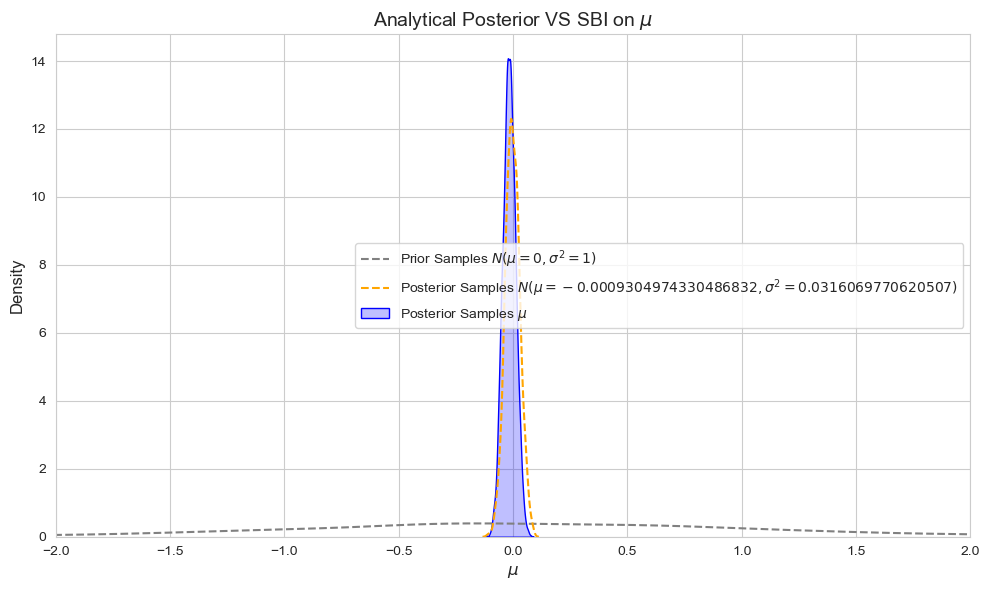

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # Extract the first dimension (mu) from the samples
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Generate samples from the Prior distribution
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# Generate samples from the Posterior distribution
posterior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(posterior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange", linestyle="--")

# Plot the KDE for the Posterior samples using sampled data
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# If needed, plot the true theta value
theta_true_value = theta_true[0, 0].item()

# Uncomment to plot the true value line
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")

ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(-2, 2)

# Show the plot
plt.tight_layout()
plt.show()


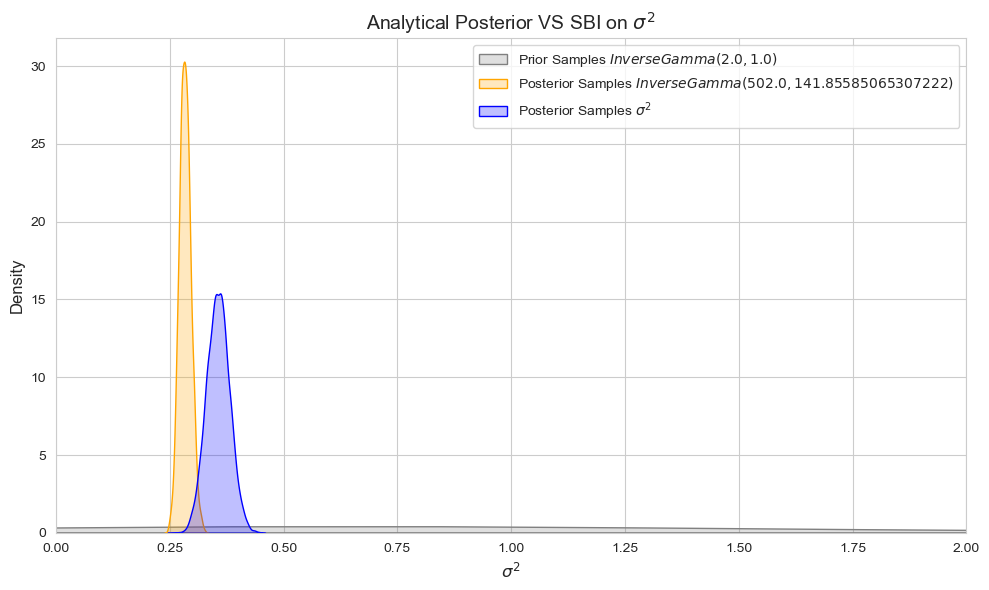

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract the second dimension (\sigma^2) from the samples
sigma2_samples = samples[:, 1].numpy()  # Extract the second dimension from samples
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
alpha_prior = 2.0  # Shape parameter α
beta_prior = 1.0   # Rate parameter β

# Convert to Inverse Gamma distribution samples
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# Convert to Inverse Gamma distribution samples for the posterior
posterior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(posterior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")

# Plot the KDE for the posterior samples using sampled data
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# If needed, add a vertical line for the true value
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# Add legend, title, and labels
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(0, 2)

# Show the plot
plt.tight_layout()
plt.show()


In [59]:
# new test data
posterior = inference.build_posterior(density_estimator)
theta_true = torch.tensor([[-0.3,1]]) # mu= -0.3, sigma^2 =1 
x_obs = simulator(theta_true)
samples = posterior.sample((10000,), x=x_obs)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [60]:
import numpy as np

# Prior parameters
mu_0 = 0
sigma_0_sq = 1  # Prior variance
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Data preparation
Z = x_obs.numpy()  # If PyTorch tensor, convert to NumPy array
Z_flat = Z.flatten()  # Flatten to a one-dimensional array

# Sample mean and sample size
Y_mean = np.mean(Z_flat)  # Sample mean
n = Z.size  # Sample size

# Calculate total sample variance
variance = np.sum((Z_flat - Y_mean) ** 2)  # Total variance

kappa_0 = 1
kappa_n = kappa_0 + n

# Posterior parameter calculations
# Posterior for sigma^2
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# Posterior for mu
sigma_poster_sq = sigma_0_sq / (kappa_0 + n)  # Posterior variance
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # Posterior mean

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 518.5867826070529
Posterior mu (mean): -0.32904619103545074
Posterior sigma^2 (variance): 0.000999000999000999


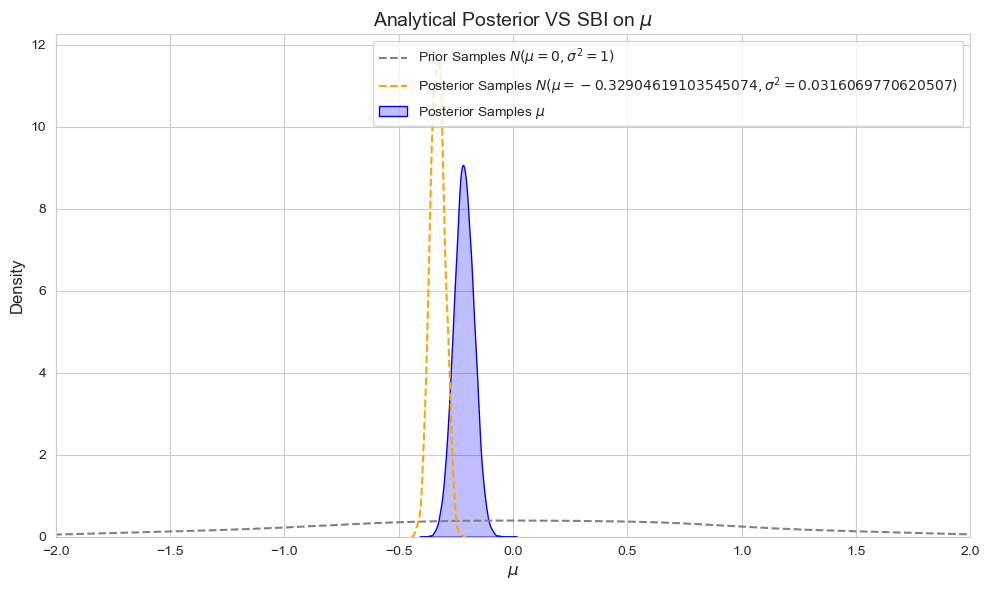

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

mu_samples = samples[:, 0].numpy()  # Extract the first dimension (mu) from the samples
theta_true = theta_true.numpy() if torch.is_tensor(theta_true) else theta_true
num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Generate samples from the Prior distribution
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# Generate samples from the Posterior distribution
posterior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(posterior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange", linestyle="--")

# Plot the KDE for the Posterior samples using sampled data
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# If needed, plot the true theta value
theta_true_value = theta_true[0, 0].item()

# Uncomment to plot the true value line
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\mu$ = {theta_true_value}")

ax.set_title("Analytical Posterior VS SBI on $\mu$", fontsize=14)
ax.set_xlabel(r"$\mu$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(-2, 2)

# Show the plot
plt.tight_layout()
plt.show()


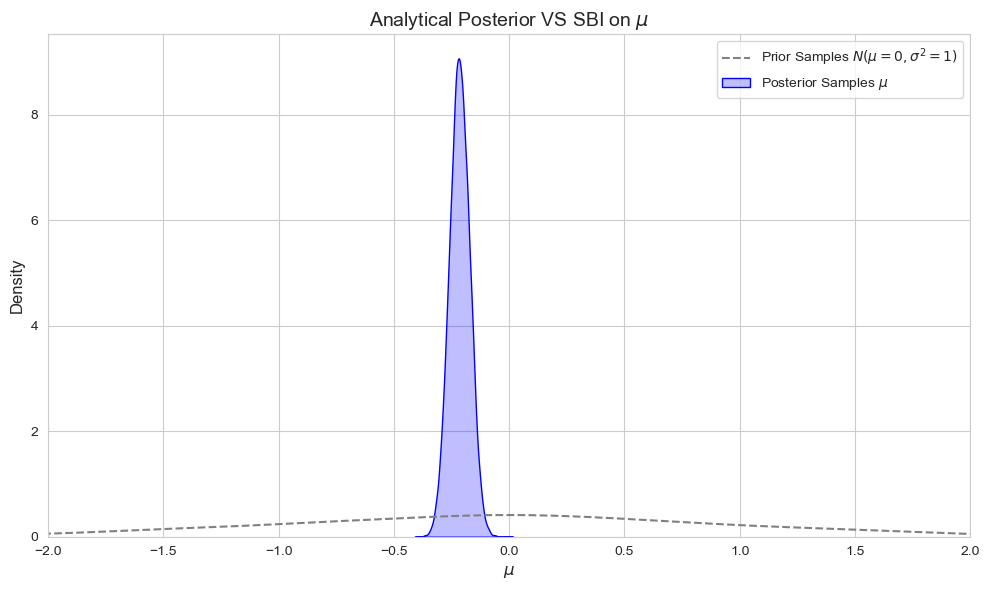

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract the second dimension (\sigma^2) from the samples
sigma2_samples = samples[:, 1].numpy()  # Extract the second dimension from samples
theta_true_value = theta_true[0, 1].item() if torch.is_tensor(theta_true) else theta_true[0, 1]

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
alpha_prior = 2.0  # Shape parameter α
beta_prior = 1.0   # Rate parameter β

# Convert to Inverse Gamma distribution samples
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# Convert to Inverse Gamma distribution samples for the posterior
posterior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(posterior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")

# Plot the KDE for the posterior samples using sampled data
sns.kdeplot(sigma2_samples, ax=ax, fill=True, label=r"Posterior Samples $\sigma^2$", color="blue")

# If needed, add a vertical line for the true value
# ax.axvline(x=theta_true_value, color="red", linestyle="-", linewidth=2, label=f"True Value $\sigma^2$ = {theta_true_value}")

# Add legend, title, and labels
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(0, 2)

# Show the plot
plt.tight_layout()
plt.show()
